# Car Price Predictor - Model Fit
### Siraj Ali

**Dataset Location**: https://www.kaggle.com/CooperUnion/cardataset

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_parquet('../data_xform.parquet')

In [3]:
SEED = 11132020
FEATURES = df.columns.tolist()
TARGET = 'MSRP'

FEATURES.remove(TARGET)

## Split the data

Recalling from the EDA notebook, that most older cars were _significantly_ lower priced than newer cars. In order to better balance the data, we can stratified sample to ensure that the training and testing sets have equal distributions of newer and older cars.

In [4]:
"""
X = df[FEATURES]
y = df[TARGET]

# split train and test to 60% and 40%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=SEED)

# further split test to ultimately have 20% test and 20% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
"""

# stratified split based on age - 70/30 split for train and test
stratsplit = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

for train_idx, test_idx in stratsplit.split(df, df["Age"]):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
print(df_train.shape)
print(df_test.shape)

(7821, 102)
(3353, 102)


<AxesSubplot:>

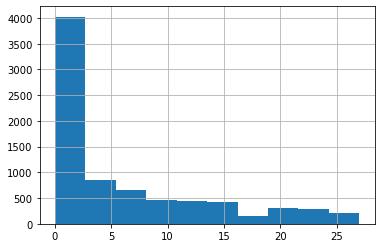

In [5]:
df_train['Age'].hist()

<AxesSubplot:>

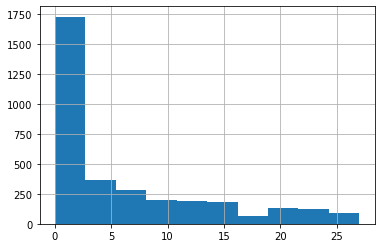

In [6]:
df_test['Age'].hist()

Separate the features and target for the train and test datasets. Also, take the log transform of the target.

In [7]:
X_train = df_train[FEATURES].values
y_train = df_train[TARGET].values

y_train_log = np.log1p(y_train)

In [8]:
X_test = df_test[FEATURES].values
y_test = df_test[TARGET].values

y_test_log = np.log1p(y_test)

## Standardize the data

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Generalized Linear Regression

In [10]:
glm = LinearRegression(fit_intercept=True, normalize=False)
glm.fit(X_train, y_train_log)

LinearRegression()

In [11]:
print('Coefficients: \n', glm.coef_)

Coefficients: 
 [ 7.46467083e-02  1.16521888e-01  1.09730639e-01 -3.39329738e-02
 -2.28363629e-01 -4.80066263e+11  9.65920098e-02 -2.45757587e-02
  2.13726564e-02  4.33442748e+10  5.47790527e-02  1.59019470e-01
 -5.03540039e-04  5.00488281e-03  1.08371735e-01  2.30407715e-03
 -7.18399048e-01 -6.79552833e+10 -1.10660354e+10 -3.94508055e+10
  8.31536323e+10  1.27916790e+11 -2.99605346e+10 -6.21694699e+10
  1.55555223e+09 -2.04475580e+10 -2.51243164e+10  1.77333320e+10
 -1.80905658e+10  3.17769785e+10  3.53713639e+11 -7.08086684e+10
 -8.31055528e+09 -1.97099141e+10  3.86184053e+10 -7.98446332e+09
 -7.69003742e+10  5.80604161e+09 -1.02226561e+10 -5.17763681e+10
 -4.87544157e+10 -5.77505188e+10 -1.68026055e+10 -3.03422172e+10
 -2.05555120e+10 -6.19800711e+10 -8.80881258e+09 -5.49787553e+10
 -5.20149789e+10  2.93363821e+10 -5.55611377e+10 -2.62080258e+10
 -5.80453208e+10  4.39852150e+09 -2.45326648e+10 -3.73942558e+10
 -3.72185135e+10 -8.41065341e+09 -4.45681165e+10 -6.42645789e+10
  3.47013

## Check the R<sup>2</sup> score for train and test sets

In [12]:
r2_train = r2_score(y_train_log, glm.predict(X_train))
print(r2_train)

0.8537437732097384


In [13]:
r2_test = r2_score(y_test_log, glm.predict(X_test))
print(r2_test)

0.8476108347630871


## Check for assumptions of linear regression

In [14]:
def calculate_residuals(model, x, y):
    predictions = model.predict(x)
    df_results = pd.DataFrame({'act_log': y, 'pred_log': predictions})
    df_results['residual'] = abs(y) - abs(predictions)
    df_results['act'] = np.expm1(y)
    df_results['pred'] = np.expm1(predictions)
    return df_results

residual_df = calculate_residuals(glm, X_test, y_test_log)

### Linearity

In [46]:
def residual_plot(df, x, y, title):
    sns.lmplot(x=x, y=y, data=df, fit_reg=False, height=7)
    line = np.arange(df[y].min(), df[y].max())
    plt.plot(line, line, color='orange', linestyle='--')
    plt.title(title)
    plt.show()

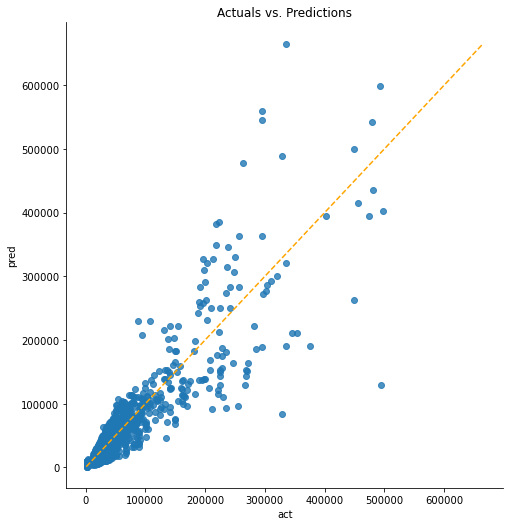

In [47]:
residual_plot(residual_df, 'act', 'pred', 'Actuals vs. Predictions')

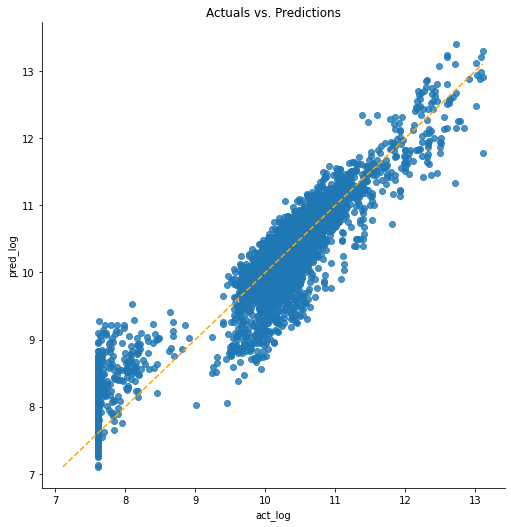

In [48]:
residual_plot(residual_df, 'act_log', 'pred_log', 'Actuals vs. Predictions')

### Normality of errors

C:\Users\siraj\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


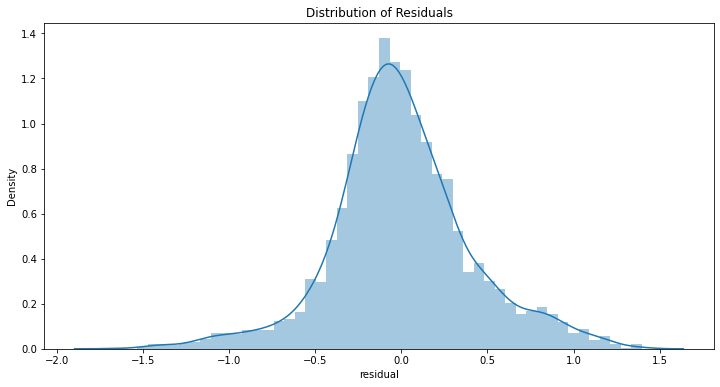

In [64]:
plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(residual_df['residual'])
plt.show()

### Homoskedasticity

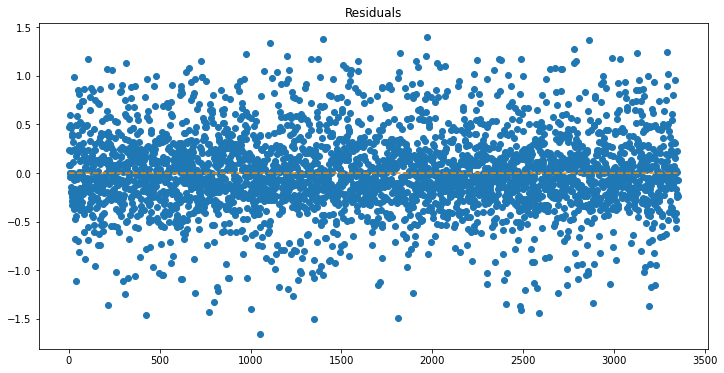

In [65]:
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=residual_df.index, y=residual_df.residual)
plt.plot(np.repeat(0, residual_df.index.max()), color='darkorange', linestyle='--')
plt.title('Residuals')
plt.show()  

## GBM

In [68]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3, 5, 8],
    "n_estimators":[10, 100, 1000]
}

gbm = GradientBoostingRegressor()
clf = GridSearchCV(gbm, parameters,refit=False, cv=5, n_jobs=-1)

In [69]:
# clf.fit(X_train, y_train)

In [78]:
gbm.fit(X_train, y_train_log)

GradientBoostingRegressor()

In [79]:
gbm_preds = gbm.predict(X_train)
r2_score(y_train_log, gbm_preds)

0.9828779087604667

In [80]:
gbm_preds = gbm.predict(X_test)
r2_score(y_test_log, gbm_preds)

0.9803992811892216

In [82]:
calculate_residuals(gbm, X_test, y_test_log)

,act_log,pred_log,residual,act,pred
0,11.061956,10.907669,0.154287,63700.0,54592.431699
1,10.163965,10.374697,-0.210732,25950.0,32037.609504
2,9.568015,9.695728,-0.127714,14299.0,16247.053904
3,10.732061,10.679259,0.052803,45800.0,43444.332242
4,12.310392,12.386852,-0.076460,221990.0,239629.234625
...,...,...,...,...,...
3348,10.136581,10.091960,0.044622,25249.0,24147.072995
3349,10.008118,10.017450,-0.009332,22205.0,22413.193492
3350,10.815790,10.628768,0.187022,49800.0,41305.202865
3351,10.696390,10.743421,-0.047031,44195.0,46323.237943


In [ ]:
#todo